# Programm zur Erkennung von Hunderassen

## Schritt 1: Daten laden und Aufteilen in Trainings- und Testdaten

In [1]:
# Importieren der notwendigen Bibliotheken
import os
import numpy as np
import xml.etree.ElementTree as ET
from skimage import io, color, transform
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [2]:
# Definieren der Pfade zum Datensatz und zu den Annotationen
dataset_path = 'dogs'
annotation_path = 'annotations'


In [3]:
# Funktion zum Parsen der Annotationsdateien
def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    bndboxes = []
    for obj in root.findall('object'):
        bndbox = obj.find('bndbox')
        xmin = int(float(bndbox.find('xmin').text))
        ymin = int(float(bndbox.find('ymin').text))
        xmax = int(float(bndbox.find('xmax').text))
        ymax = int(float(bndbox.find('ymax').text))
        bndboxes.append((xmin, ymin, xmax, ymax))
    return bndboxes


In [4]:
# Laden der Bilder und Extrahieren der Hundebereiche
images = []
labels = []
breeds = os.listdir(dataset_path)

for breed in breeds:
    breed_img_path = os.path.join(dataset_path, breed)
    breed_anno_path = os.path.join(annotation_path, breed)
    if os.path.isdir(breed_img_path):
        for img_name in os.listdir(breed_img_path):
            img_path = os.path.join(breed_img_path, img_name)
            annotation_name = os.path.splitext(img_name)[0]
            annotation_file = os.path.join(breed_anno_path, annotation_name)
            if not os.path.exists(annotation_file):
                continue  # Überspringe Bilder ohne Annotation
            image = io.imread(img_path)
            if image is None:
                continue
            bndboxes = parse_annotation(annotation_file)
            for bndbox in bndboxes:
                xmin, ymin, xmax, ymax = bndbox
                xmin = max(0, xmin)
                ymin = max(0, ymin)
                xmax = min(image.shape[1], xmax)
                ymax = min(image.shape[0], ymax)
                if xmin >= xmax or ymin >= ymax:
                    continue  # Ungültige Bounding Box überspringen
                cropped_image = image[ymin:ymax, xmin:xmax]
                cropped_image = transform.resize(cropped_image, (256, 256))
                images.append(cropped_image)
                labels.append(breed)


In [5]:
# Umwandeln der Labels in numerische Werte
le = LabelEncoder()
y = le.fit_transform(labels)

# Überprüfen, ob Bilder geladen wurden
if len(images) == 0:
	print("Fehler: Keine Bilder geladen. Bitte überprüfen Sie den Pfad und die Annotationsdateien.")
else:
	# Aufteilen in Trainings- und Testdaten
	X_train_img, X_test_img, y_train, y_test = train_test_split(images, y, test_size=0.25, stratify=y, random_state=42)


In [6]:
# Überprüfen der Anzahl der geladenen Bilder
print(f'Anzahl der gesamten Bilder: {len(images)}')
print(f'Anzahl der Trainingsbilder: {len(X_train_img)}')
print(f'Anzahl der Testbilder: {len(X_test_img)}')


Anzahl der gesamten Bilder: 1029
Anzahl der Trainingsbilder: 771
Anzahl der Testbilder: 258


## 2./3. Schritt: Netzarchitektur festlegen und implementieren

## 4. Schritt: Wahl einer geeigneten Lossfunktion und eines Optimizers

In [7]:
# Beispiel eines Modells mit Convolutional Layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def build_model():
    model = Sequential()
    
    # Erste Convolutional-Schicht
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256,256,3)))
    model.add(MaxPooling2D((2, 2)))
    
    # Zweite Convolutional-Schicht
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    # Dritte Convolutional-Schicht
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    # Modellzusammenfassung, um die Form nach den Convolutional Layers zu überprüfen
    #model.summary()  # Dies gibt dir die Dimensionen der Ausgaben nach jeder Schicht aus
    
    # Flatten-Schicht, um die Dimensionen auf einen Vektor zu reduzieren
    model.add(Flatten())
    
    # Dense Layer
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  # Dropout zur Vermeidung von Overfitting
    model.add(Dense(5, activation='softmax'))  # Softmax für Multiklassenklassifikation
    
    return model


In [8]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Daten vorbereiten (Images und Labels)
X_train_img = np.array(X_train_img) / 255.0  # Normalisierung der Bilddaten
X_test_img = np.array(X_test_img) / 255.0

# Labels als Integer belassen (für SparseCategoricalCrossentropy)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Kreuzvalidierung (3-fold)
kf = KFold(n_splits=3, shuffle=True, random_state=42)
fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_img, y_train)):
    print(f"\n### Fold {fold + 1} ###")
    
    # Train/Validation-Split für diesen Fold
    X_fold_train, X_fold_val = X_train_img[train_idx], X_train_img[val_idx]
    y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

    # Neues Modell für jeden Fold
    model = build_model()
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Modell trainieren
    history = model.fit(X_fold_train, y_fold_train,
                        validation_data=(X_fold_val, y_fold_val),
                        epochs=20,  # Anzahl der Epochen
                        batch_size=16,
                        verbose=1)

    # Validierungsergebnisse speichern
    val_loss, val_accuracy = model.evaluate(X_fold_val, y_fold_val, verbose=0)
    fold_results.append((val_loss, val_accuracy))
    print(f"Fold {fold + 1} - Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")


### Fold 1 ###


C:\Users\OIJ1FE\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 390ms/step - accuracy: 0.2376 - loss: 1.6146 - val_accuracy: 0.2529 - val_loss: 1.6045
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 357ms/step - accuracy: 0.2692 - loss: 1.6026 - val_accuracy: 0.2529 - val_loss: 1.5998
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 399ms/step - accuracy: 0.2332 - loss: 1.6020 - val_accuracy: 0.2529 - val_loss: 1.5977
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 363ms/step - accuracy: 0.2768 - loss: 1.5871 - val_accuracy: 0.2529 - val_loss: 1.6022
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 377ms/step - accuracy: 0.2040 - loss: 1.6078 - val_accuracy: 0.2529 - val_loss: 1.5999
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 366ms/step - accuracy: 0.2561 - loss: 1.6070 - val_accuracy: 0.2529 - val_loss: 1.5984
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 371ms/step - accuracy: 0.2595 - loss: 1.5988 - val_accuracy: 0.2529 - val_loss: 1.5991
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 372ms/step - accuracy: 0.2685 - loss: 1.5979 - val_accu

In [9]:
# Durchschnittliche Validierungsergebnisse
avg_val_loss = np.mean([result[0] for result in fold_results])
avg_val_accuracy = np.mean([result[1] for result in fold_results])
print(f"\nDurchschnittliche Validierungs-Performance: Loss = {avg_val_loss:.4f}, Accuracy = {avg_val_accuracy:.4f}")

# Evaluation auf den Testdaten
test_loss, test_accuracy = model.evaluate(X_test_img, y_test, verbose=0)
print(f"\nTestdaten-Performance: Loss = {test_loss:.4f}, Accuracy = {test_accuracy:.4f}")

# Klassifikationsbericht
y_test_pred = np.argmax(model.predict(X_test_img), axis=1)
print("\nKlassifikationsbericht für Testdaten:")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))


Durchschnittliche Validierungs-Performance: Loss = 1.5986, Accuracy = 0.2568

Testdaten-Performance: Loss = 1.5971, Accuracy = 0.2558
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 195ms/step

Klassifikationsbericht für Testdaten:
                                      precision    recall  f1-score   support

               n02085936-Maltese_dog       0.26      1.00      0.41        66
                    n02091831-Saluki       0.00      0.00      0.00        56
        n02093859-Kerry_blue_terrier       0.00      0.00      0.00        48
                n02104365-schipperke       0.00      0.00      0.00        43
n02107574-Greater_Swiss_Mountain_dog       0.00      0.00      0.00        45

                            accuracy                           0.26       258
                           macro avg       0.05      0.20      0.08       258
                        weighted avg       0.07      0.26      0.10       258



C:\Users\OIJ1FE\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\OIJ1FE\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\OIJ1FE\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

## Evaluation mit der Kreuzvalidierung

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


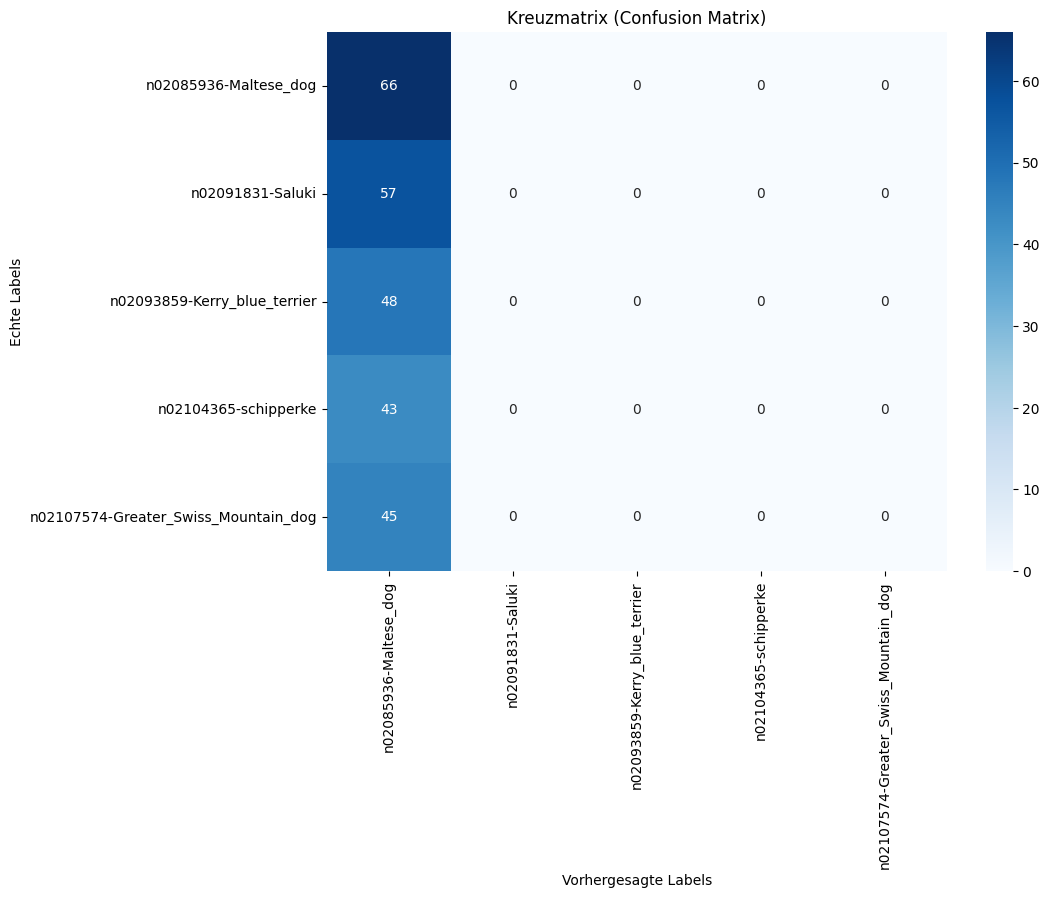

In [10]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Annahme: fold_results enthält jetzt (val_loss, val_accuracy) und wir berechnen zusätzlich die Vorhersagen für jedes Fold
y_true_all = []
y_pred_all = []

# Iteriere durch alle Folds
for i, (val_loss, val_accuracy) in enumerate(fold_results):
    # Hole die tatsächlichen Labels für das aktuelle Fold
    y_fold_val = y_test[i * len(X_fold_val):(i + 1) * len(X_fold_val)]  # Beispielweise so aus X_fold_val
    X_fold_val = X_test_img[i * len(X_fold_val):(i + 1) * len(X_fold_val)]  # Ähnlich wie X_test

    # Berechne die Vorhersagen für das aktuelle Fold
    y_fold_pred = model.predict(X_fold_val)
    y_fold_pred = np.argmax(y_fold_pred, axis=1)  # Für Mehrklassenklassifikation, Umwandlung in Klassenlabels
    
    # Füge die Vorhersagen und die tatsächlichen Labels zu den Listen hinzu
    y_true_all.extend(y_fold_val)
    y_pred_all.extend(y_fold_pred)

# 2. Berechnung der Kreuzmatrix
conf_matrix = confusion_matrix(y_true_all, y_pred_all)

# 3. Visualisierung der Kreuzmatrix mit Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Vorhergesagte Labels')
plt.ylabel('Echte Labels')
plt.title('Kreuzmatrix (Confusion Matrix)')
plt.show()
